# the Inplementation of Band-Limited Angular Spectrum Method (3D)

In [1]:
import torch
import math
import matplotlib.pyplot as plt
import cProfile

In [2]:
def AS_2D(
    source_plain=-1,
    wave_length=1,
    z=100 * 2048, # the propagation distance
    sample_u=1024,  # the number of pixels in x-axis
    sample_v=1024,  # the number of pixels in y-axis
    clipper_u=-1,
    clipper_v=-1,
):
    dx = 2 * wave_length  # the sample interval

    N_u = 2 * sample_u
    N_v = 2 * sample_v

    # generate the 2-D frequency mesh
    freq_x = torch.fft.fftfreq(N_u, dx)
    freq_y = torch.fft.fftfreq(N_v, dx)

    freq_x = torch.unsqueeze(freq_x, dim=1).expand(
        -1, len(freq_y)
    )  # expand to len(y) columns
    freq_y = torch.unsqueeze(freq_y, dim=0).expand(
        len(freq_x), -1
    )  # expand to len(x) rows
    freq_square = freq_x**2 + freq_y**2

    freq_squre_max = torch.full((N_u, N_v), 1 / wave_length) ** 2
    w_square_0 = freq_squre_max - freq_square
    mask = w_square_0 > 0
    w_square = torch.where(mask, w_square_0, 0)

    # transfer function
    H_FR = torch.empty((N_u, N_v), dtype=torch.complex64)
    H_FR = torch.exp(2j * math.pi * z * torch.sqrt(w_square))

    # generate the source plain
    g_0 = torch.zeros((N_u, N_v))
    if isinstance(source_plain, torch.Tensor):
        # load the picture
        g_0[
            N_u // 2 - sample_u // 2 : N_u // 2 + sample_u // 2,
            N_v // 2 - sample_v // 2 : N_v // 2 + sample_v // 2,
        ] = source_plain
    else:
        # a simple square
        g_0[
            N_u // 2 - 256 : N_u // 2 + 256,
            N_v // 2 - 256 : N_v // 2 + 256,
        ] = torch.ones((512, 512))

    G_0 = torch.fft.fft2(g_0)

    # the spectrum in the destination plain
    G_z = G_0 * H_FR


    G_z = torch.fft.fftshift(G_z)
    # clip the frequency in x
    if clipper_u == -1:
        pass
    else:
        G_z[: N_u // 2 + 1 - clipper_u, :] = 0
        G_z[N_u // 2 + clipper_u :, :] = 0

    # clip the frequency in y
    if clipper_v == -1:
        pass
    else:
        G_z[:, : N_v // 2 + 1 - clipper_v] = 0
        G_z[:, N_v // 2 + clipper_v :] = 0

    G_z = torch.fft.ifftshift(G_z)


    # 目标平面
    g_z = torch.fft.ifft2(G_z).abs()

    return (
        H_FR.real,
        g_z[
            int(N_u / 2) - sample_u // 2 : int(N_u / 2) + sample_u // 2,
            int(N_v / 2) - sample_v // 2 : int(N_v / 2) + sample_v // 2,
        ],
    )

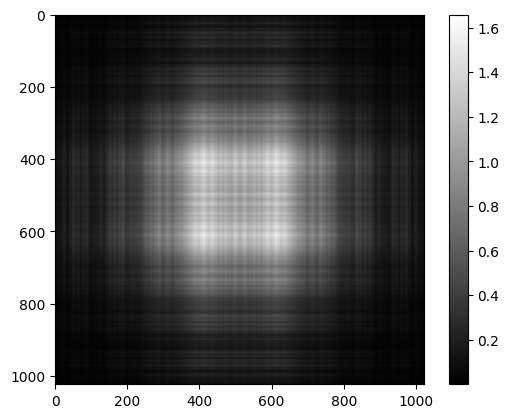

In [3]:
H_FR_2D, g_z_2D = AS_2D()
plt.imshow(g_z_2D, cmap="gray")
plt.colorbar()
plt.show()

In [4]:
def band_limited_AS_2D(source_plain = -1, wave_length=1, z=100 * 2048, sample_u=1024, sample_v=1024):
    dx = 2 * wave_length  # the sampling interval
    S_x = sample_u * dx
    S_y = sample_v * dx

    N_u = 2 * sample_u
    N_v = 2 * sample_v

    freq_u = torch.fft.fftfreq(N_u, dx)
    freq_u = torch.fft.fftshift(freq_u)

    freq_v = torch.fft.fftfreq(N_v, dx)
    freq_v = torch.fft.fftshift(freq_v)

    d_u = 1 / (2 * S_x)
    d_v = 1 / (2 * S_y)
    u_limit = 1 / (math.sqrt((2 * d_u * z) ** 2 + 1) * wave_length)
    v_limit = 1 / (math.sqrt((2 * d_v * z) ** 2 + 1) * wave_length)

    mask_u = abs(freq_u) <= (u_limit)
    if torch.all(mask_u):
        clipper_u = -1
        max_frequency_retained_u = abs(freq_u[0])
    else:
        first_true_index = torch.argmax(mask_u.to(torch.int))
        clipper_u = N_u // 2 + 1 - first_true_index
        max_frequency_retained_u = abs(freq_u[first_true_index])

    mask_v = abs(freq_v) <= (v_limit)
    if torch.all(mask_v):
        clipper_v = -1
        max_frequency_retained_v = abs(freq_v[0])
    else:
        first_true_index = torch.argmax(mask_v.to(torch.int))
        clipper_v = N_v // 2 + 1 - first_true_index
        max_frequency_retained_v = abs(freq_v[first_true_index])

    H_FR_real, g_z = AS_2D(source_plain, wave_length, z, sample_u, sample_v, clipper_u, clipper_v)

    print(
        f"u: cut-off frequency {(u_limit)} : set clipper_n to be {clipper_u} (the max frequency retained : {max_frequency_retained_u})\n",
        f"v: cut-off frequency {(v_limit)} : set clipper_n to be {clipper_v} (the max frequency retained : {max_frequency_retained_v})\n",
    )

    return max_frequency_retained_u, max_frequency_retained_v, g_z

u: cut-off frequency 0.009999500037496875 : set clipper_n to be 41 (the max frequency retained : 0.009765625)
 v: cut-off frequency 0.009999500037496875 : set clipper_n to be 41 (the max frequency retained : 0.009765625)



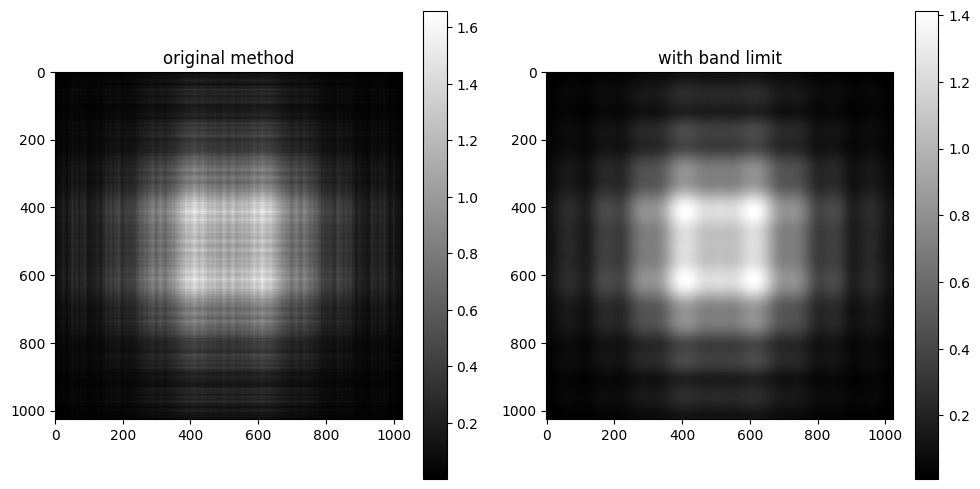

In [5]:
H_FR_2D, g_z_2D = AS_2D()
u, v, band_limited_g_z_2D = band_limited_AS_2D()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

im1 = axes[0].imshow(g_z_2D, cmap="gray")
fig.colorbar(im1, ax=axes[0])
axes[0].set_title("original method")

im2 = axes[1].imshow(band_limited_g_z_2D, cmap="gray")
fig.colorbar(im2, ax=axes[1])
axes[1].set_title("with band limit")

plt.tight_layout()
plt.show()

In [6]:
cProfile.run('band_limited_AS_2D()')

u: cut-off frequency 0.009999500037496875 : set clipper_n to be 41 (the max frequency retained : 0.009765625)
 v: cut-off frequency 0.009999500037496875 : set clipper_n to be 41 (the max frequency retained : 0.009765625)

         149 function calls in 0.176 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.176    0.176 1361153546.py:1(band_limited_AS_2D)
        1    0.051    0.051    0.176    0.176 1905928165.py:1(AS_2D)
        1    0.000    0.000    0.176    0.176 <string>:1(<module>)
        7    0.000    0.000    0.005    0.001 _tensor.py:34(wrapped)
        4    0.000    0.000    0.000    0.000 _tensor.py:907(__rsub__)
        4    0.000    0.000    0.000    0.000 _tensor.py:929(__format__)
        2    0.000    0.000    0.000    0.000 _tensor.py:964(__len__)
        1    0.000    0.000    0.000    0.000 iostream.py:138(_event_pipe)
        1    0.000    0.000    0.000    0.000 iostream